# Demo 04 — Implied Volatility

This notebook demonstrates how to compute **Black–Scholes implied volatility (IV)** by **inverting** a pricing model:

- **Core usage (what you’ll do in practice):** call `implied_vol_bs_result(mkt_price=..., spec=..., market=..., cfg=..., sigma0=...)`
- **One price → one IV:** a single “golden” inversion sanity check
- **IV curve across strikes (“smile”):** repeat the inversion across a strike grid (using synthetic prices)
- **When IV fails:** no-arbitrage bounds and bracketing
- **Regression checks:** a small suite of published Black–Scholes benchmarks

> In real markets you invert **observed prices** (often mid = (bid + ask)/2).  
> In this demo we generate **synthetic** prices so we can validate the solver end-to-end.

---

## Imports

We keep the notebook light by importing the reusable diagnostics helpers.


In [1]:
from dataclasses import replace

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from option_pricing import MarketData, OptionSpec, OptionType, PricingInputs, bs_price
from option_pricing.config import ImpliedVolConfig

# Diagnostics helpers (compute + plots)
from option_pricing.diagnostics.iv.benchmarks import (
    run_bs_iv_benchmarks,
    run_synthetic_iv_smile,
)
from option_pricing.diagnostics.iv.plots import plot_iv_smile
from option_pricing.numerics.root_finding import (
    RootMethod,  # low-level (legacy-style)
)
from option_pricing.vol.implied_vol import implied_vol_bs_result

In [2]:
def show_iv(ivres):
    """Pretty-print an implied-vol root finding result."""
    print("IV:", ivres.vol)
    rr = ivres.root_result
    print("  method:", rr.method)
    print("  converged:", rr.converged)
    print("  iterations:", rr.iterations)
    print("  f_at_root:", rr.f_at_root)
    print("  bracket:", rr.bracket)

## Setup

We fix a single market configuration `(S, r, q, τ)` and create a template option `p_call`.  
All pricing and IV inversions below reuse this setup so results are comparable.

---

In [3]:
S, r, q, tau = 100.0, 0.05, 0.0, 1.0

market = MarketData(spot=S, rate=r, dividend_yield=q)

# A template call we will reuse (expiry is absolute time; with t=0, tau = expiry)
spec_call = OptionSpec(kind=OptionType.CALL, strike=100.0, expiry=tau)
p_call = PricingInputs(spec=spec_call, market=market, sigma=0.25, t=0.0)

p_call

PricingInputs(spec=OptionSpec(kind=<OptionType.CALL: 'call'>, strike=100.0, expiry=1.0), market=MarketData(spot=100.0, rate=0.05, dividend_yield=0.0), sigma=0.25, t=0.0)

## Benchmark: one price → implied vol (direct `implied_vol_bs_result`)

We first demonstrate the **actual API call** you’ll use:

1) choose a “true” volatility `sigma_true`  
2) compute a synthetic market price `mkt_price = bs_price(p_true)`  
3) recover `iv` by calling `implied_vol_bs_result` starting from a guess `sigma_guess`

Because the market price is generated by the **same model** we invert, recovery should be essentially exact (up to numerical tolerances).

---

In [4]:
sigma_true = 0.35

# Synthetic "market" price generated from the same model (BS)
p_true = replace(p_call, sigma=sigma_true)
mkt_price = bs_price(p_true)

# Invert that price to recover IV
p_guess = replace(p_call, sigma=0.20)

# Config-driven API: choose solver + bounds + tolerances via ImpliedVolConfig
cfg = ImpliedVolConfig(
    root_method=RootMethod.BRACKETED_NEWTON, sigma_lo=1e-8, sigma_hi=5.0
)
cfg = replace(cfg, numerics=replace(cfg.numerics, abs_tol=1e-14, rel_tol=1e-14))

iv = implied_vol_bs_result(
    mkt_price=mkt_price,
    spec=p_call.spec,
    market=p_call.market,
    cfg=cfg,
    t=p_call.t,
    sigma0=p_guess.sigma,
)
show_iv(iv)

abs_err = abs(iv.vol - sigma_true)
print("mkt_price:", mkt_price)
print("implied_vol:", iv)
print("abs_error:", abs_err)

# We generated the market price from the same BS model, so recovery should be ~ machine precision.
assert abs_err < 1e-10

IV: 0.3499999999999999
  method: bracketed_newton
  converged: True
  iterations: 3
  f_at_root: 0.0
  bracket: (0.3499999743044391, 0.3513122284434713)
mkt_price: 16.12842888157588
implied_vol: ImpliedVolResult(vol=0.3499999999999999, root_result=RootResult(root=0.3499999999999999, converged=True, iterations=3, method='bracketed_newton', f_at_root=0.0, bracket=(0.3499999743044391, 0.3513122284434713)), mkt_price=16.12842888157588, bounds=(4.877057549928594, 100.0), tau=1.0)
abs_error: 5.551115123125783e-17


## Synthetic smile (sweep strikes)

To *see* a smile, the prices must **embed** a smile.

We define a strike-dependent “true vol” function `true_vol(K)` and then:

- generate a synthetic “market” price at each strike using `bs_price` with `sigma_true(K)`
- recover implied vol at each strike by calling `implied_vol_bs_result` (via a shared config)

This produces two curves:
- **True σ(K)** used to generate prices
- **Recovered IV(K)** from inversion

They should match closely if the implementation is correct.

---

In [5]:
def true_vol(K: float) -> float:
    x = np.log(K / S)
    return 0.20 - 0.10 * x + 0.25 * (x**2)


# Shared solver config for the whole sweep
cfg_smile = ImpliedVolConfig(
    root_method=RootMethod.BRACKETED_NEWTON,
    sigma_lo=1e-8,
    sigma_hi=5.0,
)

df_smile = run_synthetic_iv_smile(
    S=S,
    r=r,
    q=q,
    tau=tau,
    kind=OptionType.CALL,
    K_min=60.0,
    K_max=160.0,
    n=51,
    true_vol_fn=true_vol,
    sigma_guess=0.25,
    cfg=cfg_smile,
    drop_failed=False,
)

df_smile.head()

,K,sigma_true,mkt_price,implied_vol,abs_error,converged,iterations
0,60.0,0.316318,43.287825,0.316318,9.197088e-13,True,5
1,62.0,0.304933,41.416629,0.304933,5.551115e-17,True,5
2,64.0,0.294422,39.552845,0.294422,1.054712e-15,True,5
3,66.0,0.284715,37.697773,0.284715,8.421597e-13,True,4
4,68.0,0.275750,35.852997,0.275750,2.220446e-16,True,4


(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'IV smile from synthetic prices (skew + curvature)'}, xlabel='Strike K', ylabel='Implied vol'>)

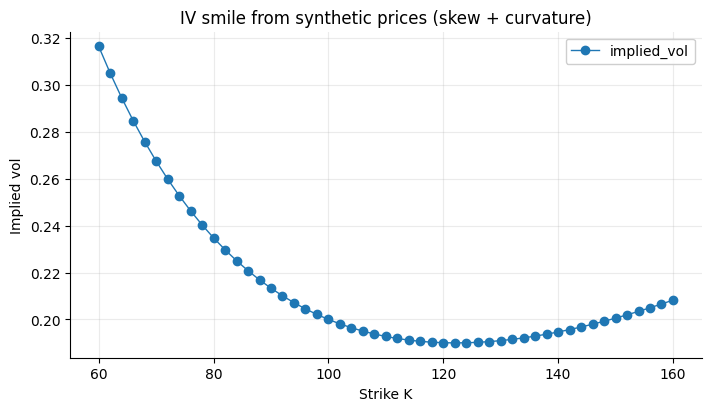

In [6]:
plot_iv_smile(
    df_smile,
    x="K",
    title="IV smile from synthetic prices (skew + curvature)",
)

## Numerical sanity: inversion error across strikes

We plot the error `IV(K) - sigma_true(K)` to confirm the recovered vols match the generating vols across the whole strike grid.

If the error grows in the wings (deep ITM/OTM), it is often due to **small vega** (the inversion becomes ill-conditioned).

---


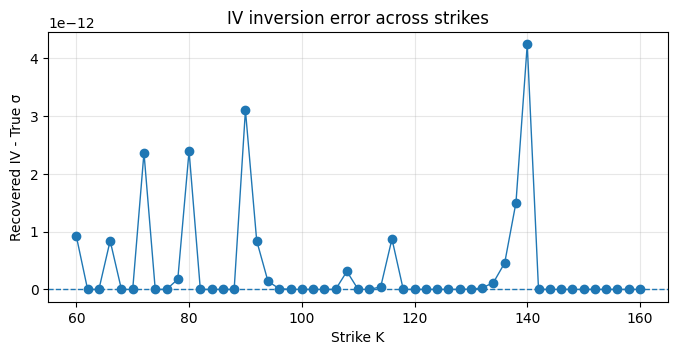

max abs error: 4.241190731946176e-12


In [7]:
# Numerical sanity: recovered IV should match sigma_true(K) very closely.
plt.figure(figsize=(8, 3.5))
plt.plot(
    df_smile["K"],
    df_smile["implied_vol"] - df_smile["sigma_true"],
    marker="o",
    linewidth=1,
)
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("Strike K")
plt.ylabel("Recovered IV - True σ")
plt.title("IV inversion error across strikes")
plt.grid(True, alpha=0.3)
plt.show()

print(
    "max abs error:",
    float(np.nanmax(np.abs(df_smile["implied_vol"] - df_smile["sigma_true"]))),
)

## No-arbitrage bounds (why IV may not exist)

Implied volatility only exists if the market price is **arbitrage-free**.

For calls (with continuous dividend yield `q`), the price must satisfy:

- lower bound: `max(0, S·exp(-qτ) - K·exp(-rτ))`
- upper bound: `S·exp(-qτ)`

If a price lies outside these bounds, no volatility can make Black–Scholes match it, and root finding will fail (typically “root not bracketed”).

---

In [8]:
# Example: no-arbitrage bounds across strikes (call)
disc_r = np.exp(-r * tau)
disc_q = np.exp(-q * tau)

K_grid = np.linspace(60, 160, 6)
bounds = []
for K in K_grid:
    lo = max(0.0, S * disc_q - float(K) * disc_r)
    hi = S * disc_q
    bounds.append((float(K), lo, hi))

pd.DataFrame(bounds, columns=["K", "call_lb", "call_ub"])

,K,call_lb,call_ub
0,60.0,42.926235,100.0
1,80.0,23.901646,100.0
2,100.0,4.877058,100.0
3,120.0,0.000000,100.0
4,140.0,0.000000,100.0
5,160.0,0.000000,100.0


## Regression: published Black–Scholes benchmarks

Finally, we run a small suite of “golden” benchmarks that check:

1) `bs_price` matches published reference prices (within tolerance)  
2) `implied_vol_bs_result` (or the `implied_vol_bs` convenience wrapper) recovers the reference `sigma_true` from those prices

Published prices are often rounded, so IV recovery tolerances should be realistic (often `1e-4` to `1e-3` depending on rounding and solver tolerances).

In [10]:
# Use the same implied-vol config across the whole benchmark suite
cfg_bench = ImpliedVolConfig(sigma_lo=1e-8, sigma_hi=5.0)

df_bench = run_bs_iv_benchmarks(
    price_tol=5e-4,
    iv_tol=5e-4,
    cfg=cfg_bench,
    save_csv_path=None,
    strict=False,
)

df_bench

,tau,K,kind,sigma_true,price,implied_vol,abs_price_err,abs_iv_err,converged,iterations
0,0.25,60.0,OptionType.CALL,0.05,4.019863e+01,1.000000e-08,0.000000e+00,4.999999e-02,True,0
1,0.25,60.0,OptionType.CALL,0.20,4.019863e+01,2.000000e-01,0.000000e+00,0.000000e+00,True,0
2,0.25,60.0,OptionType.CALL,0.50,4.033563e+01,5.000000e-01,0.000000e+00,8.215650e-15,True,8
3,0.25,60.0,OptionType.CALL,1.00,4.316055e+01,1.000000e+00,4.973799e-14,6.661338e-15,True,5
4,0.25,60.0,OptionType.PUT,0.05,6.445586e-96,1.000000e-08,6.445586e-96,4.999999e-02,True,0
...,...,...,...,...,...,...,...,...,...,...
219,2.00,140.0,OptionType.CALL,1.00,4.400489e+01,1.000000e+00,0.000000e+00,2.220446e-16,True,5
220,2.00,140.0,OptionType.PUT,0.05,3.382719e+01,5.000000e-02,7.631229e-12,7.833893e-10,True,13
221,2.00,140.0,OptionType.PUT,0.20,3.625348e+01,2.000000e-01,0.000000e+00,0.000000e+00,True,0
222,2.00,140.0,OptionType.PUT,0.50,5.128740e+01,5.000000e-01,0.000000e+00,1.665335e-16,True,4
